In [1]:
pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install moviepy


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [45]:
import cv2
import pandas as pd
import numpy as np
from moviepy.editor import VideoFileClip

# Extract frames from the video
def extract_frames(video_path, interval):
    clip = VideoFileClip(video_path)
    frames = []
    for t in np.arange(0, clip.duration, interval):
        frame = cv2.cvtColor(clip.get_frame(t), cv2.COLOR_RGB2GRAY)
        frames.append(frame)
    return frames

# Calculate optical flow
def calculate_flow(prev_frame, curr_frame):
    # Parameters for ShiTomasi corner detection
    feature_params = dict(maxCorners = 100, qualityLevel = 0.3, minDistance = 7, blockSize = 7)
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Detect corners in the previous frame
    prev_pts = cv2.goodFeaturesToTrack(prev_frame, mask = None, **feature_params)

    # If corners were detected, calculate optical flow
    if prev_pts is not None:
        curr_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_frame, curr_frame, prev_pts, None, **lk_params)
        valid_prev_pts = prev_pts[status == 1]
        valid_curr_pts = curr_pts[status == 1]

        # Calculate motion vectors
        motion_vectors = valid_curr_pts - valid_prev_pts

        # Calculate average motion vector
        avg_motion_vector = np.mean(motion_vectors, axis=0)

        # Ensure the result is a 2-dimensional array
        return avg_motion_vector.reshape(1, -1)

    return None

# Main processing function
def process_video(video_path, interval=0.033333333333333):
    frames = extract_frames(video_path, interval)
    data = []

    for i in range(1, len(frames)):
        flow = calculate_flow(frames[i-1], frames[i])
        if flow is not None:
            data.append([i, flow[0, 0], flow[0, 1]])

    return pd.DataFrame(data, columns=['Frame', 'FlowX', 'FlowY'])

video_path = '20231215124326_000556.MP4'
df = process_video(video_path)
df.to_csv(video_path[:-4] + '-vibration_data.csv', index=False)

In [33]:
df

,Frame,FlowX,FlowY
0,1,-0.000120,-0.001026
1,2,0.000370,-0.001550
2,3,-0.001208,-0.003536
3,4,0.000117,-0.000212
4,5,-0.000080,0.000438
...,...,...,...
8995,8996,-0.058186,0.094310
8996,8997,-0.006817,0.084829
8997,8998,-0.048249,0.071493
8998,8999,0.007901,0.034396


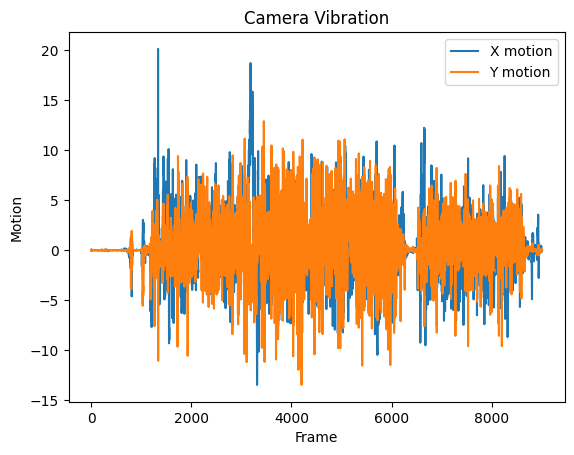

In [34]:
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('vibration_data.csv')

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the X and Y motion vectors
ax.plot(df['Frame'], df['FlowX'], label='X motion')
ax.plot(df['Frame'], df['FlowY'], label='Y motion')

# Add labels and title
ax.set_xlabel('Frame')
ax.set_ylabel('Motion')
ax.set_title('Camera Vibration')

# Add a legend
ax.legend()

# Show the plot
plt.show()

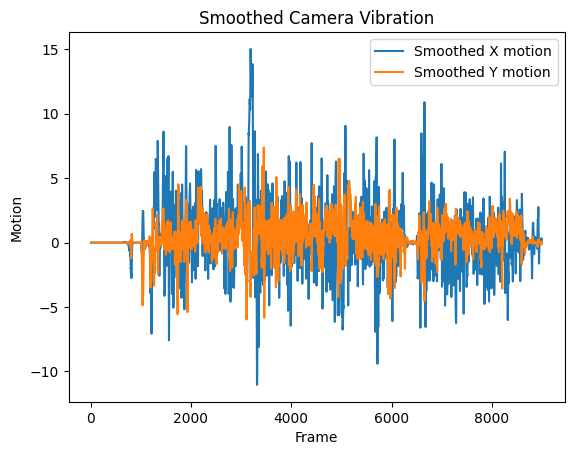

In [36]:
# Define the size of the moving average window
window_size = 10

# Apply the moving average to the X and Y motion vectors
df['SmoothFlowX'] = df['FlowX'].rolling(window_size).mean()
df['SmoothFlowY'] = df['FlowY'].rolling(window_size).mean()

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the smoothed X and Y motion vectors
ax.plot(df['Frame'], df['SmoothFlowX'], label='Smoothed X motion')
ax.plot(df['Frame'], df['SmoothFlowY'], label='Smoothed Y motion')

# Add labels and title
ax.set_xlabel('Frame')
ax.set_ylabel('Motion')
ax.set_title('Smoothed Camera Vibration')

# Add a legend
ax.legend()

# Show the plot
plt.show()